In [5]:
import os
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
import random
import shutil             # to copy images to another directory 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
plt.style.use('ggplot')




In [23]:
import opendatasets as od
import pandas
 
od.download(
    "https://www.kaggle.com/datasets/mostafaabla/garbage-classification")

Skipping, found downloaded files in ".\garbage-classification" (use force=True to force download)


In [24]:
dataDirList = ['C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/garbage_classification']

selectedClasses =  ['battery','biological','brown-glass','cardboard','clothes','green-glass','metal','paper','plastic','shoes','trash','white-glass']

In [25]:
imgPaths = []
labels = []
for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses :
            classPath = os.path.join(dataDir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                imgPaths.append(imgPath)
                if className == 'white-glass':
                    className = 'glass'
                labels.append(className)
            
# Convert the 2 lists to dataframe to easy use 
df = pd.DataFrame({
    'imgPath':imgPaths,
    'label':labels
})

df = df.sample(frac=1).reset_index(drop=True)            # Shuffle

df

imgPath        label
0      C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...        shoes
1      C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...        shoes
2      C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      clothes
3      C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      clothes
4      C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...   biological
...                                                  ...          ...
15510  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      clothes
15511  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...    cardboard
15512  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...        shoes
15513  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...  brown-glass
15514  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...        paper

[15515 rows x 2 columns]

In [27]:
# get the ratio such as 15% of each class for testing 
def DataFrameSpliting(df , ratio , classesList):
    
    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)
        
    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [28]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList)

In [29]:
trainDf

imgPath      label
0      C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      shoes
1      C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      paper
2      C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...    plastic
3      C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...    clothes
4      C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      metal
...                                                  ...        ...
13177  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...    clothes
13178  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...    clothes
13179  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...  cardboard
13180  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...    clothes
13181  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...  cardboard

[13182 rows x 2 columns]

In [30]:
trainDf['label'].value_counts()

label
clothes        4526
shoes          1680
paper           892
biological      837
battery         803
cardboard       757
plastic         735
glass           658
metal           653
trash           592
green-glass     534
brown-glass     515
Name: count, dtype: int64

In [31]:
testDf

imgPath        label
0     C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      plastic
1     C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      clothes
2     C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...  green-glass
3     C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...  green-glass
4     C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      clothes
...                                                 ...          ...
2328  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      plastic
2329  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...        paper
2330  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...    cardboard
2331  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...      clothes
2332  C:/Users/Hemanth/OneDrive/Desktop/CODE-RED/gar...        glass

[2333 rows x 2 columns]

In [32]:
testDf['label'].value_counts()

label
clothes        799
shoes          297
paper          158
biological     148
battery        142
cardboard      134
plastic        130
glass          117
metal          116
trash          105
green-glass     95
brown-glass     92
Name: count, dtype: int64

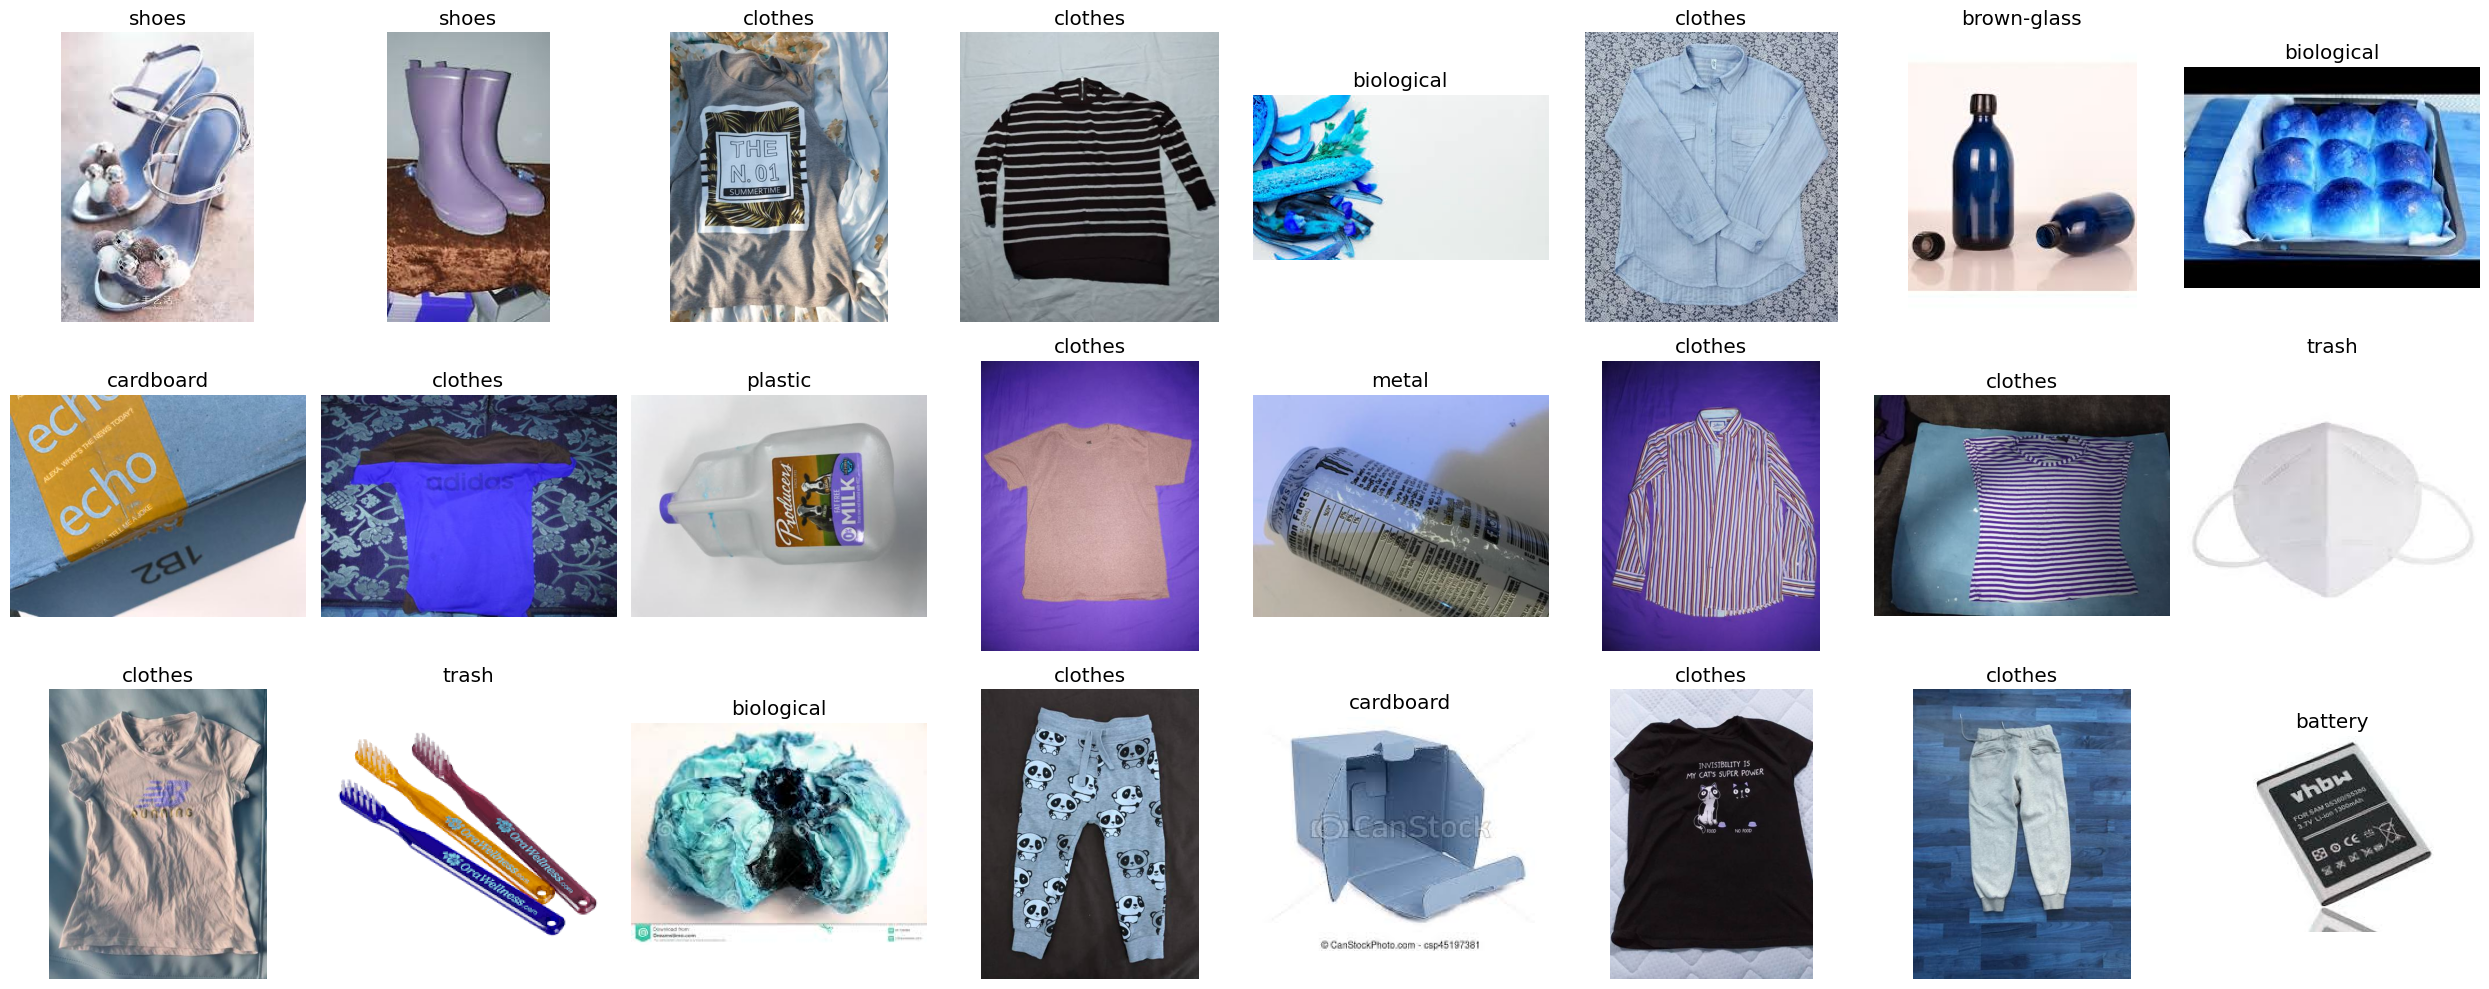

In [33]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('\\')[-2]    # extract label of an imgae from a path 
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [12]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),   # zoom in 
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

In [34]:
IMG_SIZE = (224,224)

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,                    # Generate 64 image from the datagenTrain (flipped , rotated , zoomed , ....)  at once 
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 13182 validated image filenames belonging to 12 classes.
Found 2333 validated image filenames belonging to 12 classes.
Training set size: 13182
Testing set size: 2333


In [36]:
with tf.device('/GPU:1'):          # to use GPU
    Model = Sequential([
        
#         Resizing(IMG_SIZE),
        
#         Rescaling(1./255),     These two steps ,we did perform them above with test and image generator 
    
        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),
        
        Flatten(),                                     # because we ignore the flatten and dense layers when include_top = False 
        
        Dense(64,activation='relu'),
        
        BatchNormalization(),
        
        Dropout(0.08),

        Dense(12 ,activation='softmax')
    ])

In [37]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:           # freez all layers except the first and last 3 layers, we will make them trainable (weghts changes with training)
    layer.trainable = False

In [38]:
Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [76]:
history = Model.fit(trainGenerator,
                    validation_data = testGenerator, 
                    epochs=50,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                       patience=4,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)])

C:\Users\Hemanth\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.7871 - loss: 0.7399 - val_accuracy: 0.8851 - val_loss: 0.3873
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 192s 933ms/step - accuracy: 0.9183 - loss: 0.2585 - val_accuracy: 0.9018 - val_loss: 0.3414
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.9325 - loss: 0.2085 - val_accuracy: 0.9293 - val_loss: 0.2466
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 156s 755ms/step - accuracy: 0.9433 - loss: 0.1666 - val_accuracy: 0.9297 - val_loss: 0.2674
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 158s 769ms/step - accuracy: 0.9574 - loss: 0.1382 - val_accuracy: 0.9387 - val_loss: 0.2336
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 158s 769ms/step - accuracy: 0.9632 - loss: 0.1162 - val_accuracy: 0.9211 - val_loss: 0.2885
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 183s 889ms/step - accuracy: 0.9648 - loss: 0.1075 - val_accuracy: 0.9216 - val_loss: 0.3063
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 183s 886ms/step - accuracy: 0.9687 - loss:

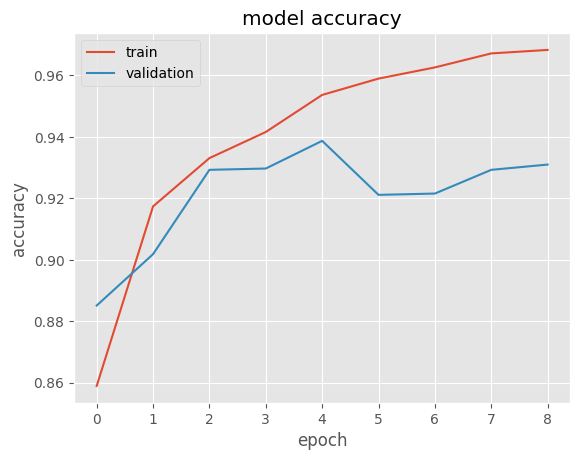

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [78]:
predictions = Model.predict(testGenerator)

292/292 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step


In [79]:
trainGenerator.class_indices

{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'glass': 5,
 'green-glass': 6,
 'metal': 7,
 'paper': 8,
 'plastic': 9,
 'shoes': 10,
 'trash': 11}

In [80]:
trueClasses = testGenerator.classes
trueClasses[:10]

[9, 8, 4, 4, 0, 5, 9, 4, 4, 5]

In [81]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([9, 8, 4, 4, 0, 5, 9, 4, 4, 5])

In [82]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

292/292 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9342 - loss: 0.2418


0.9387055039405823

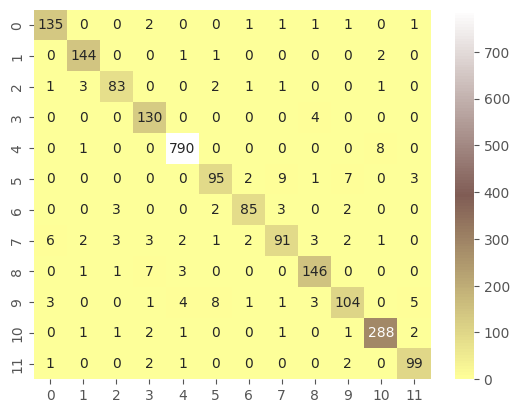

In [83]:
CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [84]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       142
           1       0.95      0.97      0.96       148
           2       0.91      0.90      0.91        92
           3       0.88      0.97      0.93       134
           4       0.99      0.99      0.99       799
           5       0.87      0.81      0.84       117
           6       0.92      0.89      0.91        95
           7       0.85      0.78      0.82       116
           8       0.92      0.92      0.92       158
           9       0.87      0.80      0.84       130
          10       0.96      0.97      0.96       297
          11       0.90      0.94      0.92       105

    accuracy                           0.94      2333
   macro avg       0.91      0.91      0.91      2333
weighted avg       0.94      0.94      0.94      2333



In [85]:
images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)  # Get next batch
    true_class_idx = np.argmax(true_labels_batch[0])  # Get the true class index
    
    # Predict the class for the image
    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])  # Get the predicted class index
    
    # Convert the class indices to class labels
    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]
    
    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)
    
    if i >= 24:  # For example, only plot 24 images
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


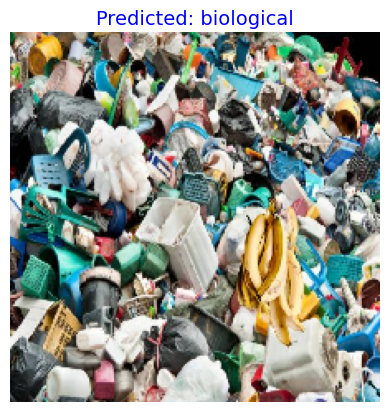

Image: Untitled design.jpg
Predicted Class: biological
Class Probabilities: [0.11339757 0.21343327 0.02221632 0.14886177 0.0402198  0.08453816
 0.01211966 0.05552945 0.0298335  0.14972375 0.11185659 0.01827018]
----------------------------------------


In [45]:
trial_folder = 'trial'

# Load the class labels
class_labels = list(testGenerator.class_indices.keys())

# Define the function to preprocess and predict
def predict_image(image_path, model, class_labels):
    # Load the image
    img = load_img(image_path, target_size=(224, 224))  # Resize to the model's input size
    img_array = img_to_array(img)  # Convert to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image (if your model requires it)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = class_labels[predicted_class_idx]

    plt.imshow(img)  # Show the original image
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}", fontsize=14, color='blue')
    plt.show()

    return predicted_class, prediction[0]

# Test the model with images in the trial folder
for image_file in os.listdir(trial_folder):
    image_path = os.path.join(trial_folder, image_file)

    if image_file.endswith(('.png', '.jpg', '.jpeg')):  # Process only valid image files
        predicted_class, probabilities = predict_image(image_path, Model, class_labels)

        print(f"Image: {image_file}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Class Probabilities: {probabilities}")
        print("-" * 40)

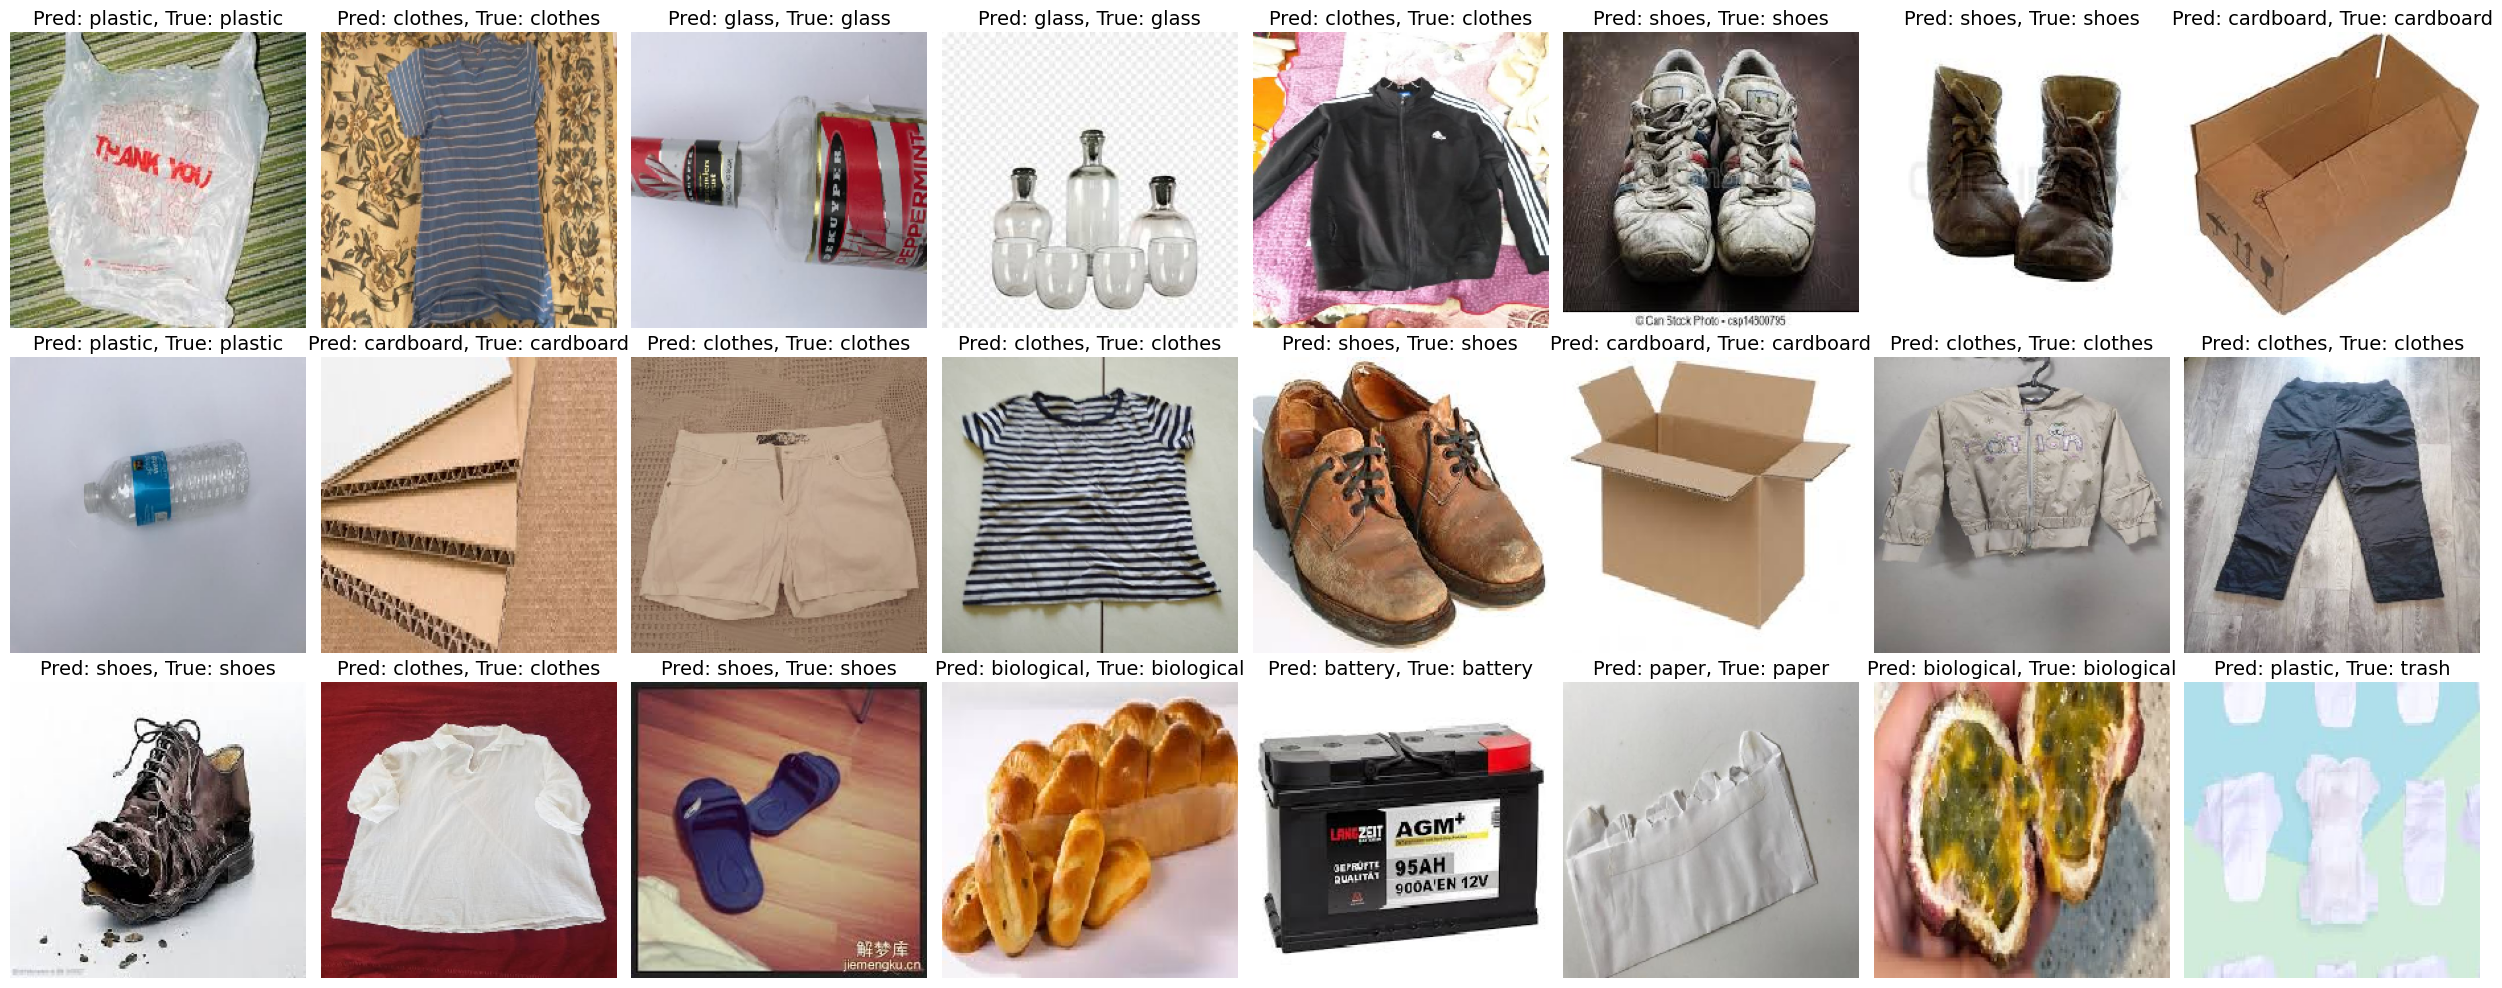

In [86]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')
    
plt.tight_layout()
plt.show()